### Cab-Driver Agent

In [3]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

/home/ravi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Defining Time Matrix

In [5]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [15]:
states_track = collections.defaultdict(dict)

In [16]:
def initialise_tracking_states():
    sample_q_values = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2)),((3,10,6),(3,4)),((0,20,3),(1,4)), ((1,23,3),(1,4))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        states_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode 

initialise_tracking_states()

In [17]:
def save_tracking_states(agent):
    for state in states_track.keys():
        for action in states_track[state].keys():
            state_encod = env.state_encod_arch1(state)
            state_encod = np.reshape(state_encod, [1, env.state_size])
            q_value = agent.model.predict(state_encod)
            action_index = env.action_space.index[action]
            states_track[state][action].append(q_value[0][action_index])

In [18]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [19]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001     
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        self.batch_size = 32        
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
        
        model.add(Dense(200, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(150, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(100, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment  
        
        possible_actions_index, actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
        
        if np.random.rand() <= epsilon:
            
            action_index = np.random.choice(possible_actions_index) #Exploration: randomly choosing any action
            action = env.action_space[action_index]
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            
            state_encod = env.state_encod_arch1(state)
            state_encod = np.reshape(state_encod, [1, self.state_size])
            q_value = self.model.predict(state_encod)
            
            possible_q_value = [q_value[0][i] for i in possible_actions_index]
            max_q_value_index = np.argmax(possible_q_value)
            action_index = possible_actions_index[max_q_value_index]
            action = actions[max_q_value_index]
            
        return action, action_index, epsilon
    

    def append_sample(self, state, action_index, reward, next_state, terminal_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        
        # Adding sample to the memory. 
        self.memory.append((state, action_index, reward, next_state, terminal_state))
        

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                state, action_index, reward, next_state, terminal_state = mini_batch[i]
                state_encod = env.state_encod_arch1(state)
                #state_encod = np.reshape(state, [1, self.state_size])
                
                next_state_encod = env.state_encod_arch1(next_state)
                #next_state_encod = np.reshape(state, [1, self.state_size])
                
                update_input[i] = state_encod
                actions.append(action_index)
                rewards.append(reward)
                terminal_states.append(terminal_state)
                update_output[i] = next_state_encod
                           
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)

            # 2. Get the target for the Q-network
            target_val = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch

            # Update the target value according to the update policy of Q-learning
            # R_t + γ ∗ max Q_t(S_{t+1},a)−Q_t(S_t,a_t)
            for i in range(self.batch_size):
                if terminal_states[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    # Q Learning: get maximum Q value at s' from target model
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (
                     np.amax(target_val[i]))
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size,
                           epochs=1, verbose=0)



    def save(self, name):
        self.model.save_weights(name)

In [28]:
Episodes = 40000

### DQN block

episode: 0   score: -123.0  step_count: 138   memory length: 138   epsilon: 1.0
episode: 25   score: -91.0  step_count: 127   memory length: 2000   epsilon: 0.9925280548938579
episode: 50   score: -95.0  step_count: 148   memory length: 2000   epsilon: 0.9851119397519432
episode: 75   score: -101.0  step_count: 131   memory length: 2000   epsilon: 0.9777512374158239
episode: 100   score: -102.0  step_count: 149   memory length: 2000   epsilon: 0.9704455338440529
episode: 125   score: -362.0  step_count: 136   memory length: 2000   epsilon: 0.9631944180888776
episode: 150   score: -9.0  step_count: 137   memory length: 2000   epsilon: 0.9559974822731252
episode: 175   score: 12.0  step_count: 138   memory length: 2000   epsilon: 0.948854321567258
episode: 200   score: -382.0  step_count: 146   memory length: 2000   epsilon: 0.9417645341666034
episode: 225   score: -157.0  step_count: 134   memory length: 2000   epsilon: 0.9347277212687504
episode: 250   score: -113.0  step_count: 141   

episode: 2100   score: -190.0  step_count: 129   memory length: 2000   epsilon: 0.5325918056809793
episode: 2125   score: -289.0  step_count: 153   memory length: 2000   epsilon: 0.5286123089798743
episode: 2150   score: -200.0  step_count: 141   memory length: 2000   epsilon: 0.5246625468599675
episode: 2175   score: -261.0  step_count: 156   memory length: 2000   epsilon: 0.5207422971460981
episode: 2200   score: -132.0  step_count: 146   memory length: 2000   epsilon: 0.5168513393231859
episode: 2225   score: -433.0  step_count: 139   memory length: 2000   epsilon: 0.5129894545238277
episode: 2250   score: -90.0  step_count: 143   memory length: 2000   epsilon: 0.509156425515985
episode: 2275   score: -58.0  step_count: 145   memory length: 2000   epsilon: 0.5053520366907656
episode: 2300   score: -204.0  step_count: 135   memory length: 2000   epsilon: 0.5015760740502949
episode: 2325   score: -156.0  step_count: 156   memory length: 2000   epsilon: 0.49782832519567877
episode: 235

episode: 4175   score: -71.0  step_count: 162   memory length: 2000   epsilon: 0.28578943659199535
episode: 4200   score: -469.0  step_count: 175   memory length: 2000   epsilon: 0.28365403366323017
episode: 4225   score: -310.0  step_count: 182   memory length: 2000   epsilon: 0.2815345863480877
episode: 4250   score: -216.0  step_count: 142   memory length: 2000   epsilon: 0.27943097542709766
episode: 4275   score: -187.0  step_count: 158   memory length: 2000   epsilon: 0.2773430825715911
episode: 4300   score: -253.0  step_count: 156   memory length: 2000   epsilon: 0.27527079033704455
episode: 4325   score: -98.0  step_count: 167   memory length: 2000   epsilon: 0.2732139821564732
episode: 4350   score: -135.0  step_count: 186   memory length: 2000   epsilon: 0.27117254233387456
episode: 4375   score: -152.0  step_count: 162   memory length: 2000   epsilon: 0.2691463560377204
episode: 4400   score: -614.0  step_count: 196   memory length: 2000   epsilon: 0.26713530929449736
episod

episode: 6250   score: -218.0  step_count: 185   memory length: 2000   epsilon: 0.15335497531137882
episode: 6275   score: 222.0  step_count: 162   memory length: 2000   epsilon: 0.15220911541735926
episode: 6300   score: 436.0  step_count: 168   memory length: 2000   epsilon: 0.15107181732565275
episode: 6325   score: -41.0  step_count: 175   memory length: 2000   epsilon: 0.14994301706294183
episode: 6350   score: 207.0  step_count: 183   memory length: 2000   epsilon: 0.14882265113391396
episode: 6375   score: 25.0  step_count: 192   memory length: 2000   epsilon: 0.14771065651769033
episode: 6400   score: -10.0  step_count: 208   memory length: 2000   epsilon: 0.14660697066428052
episode: 6425   score: -36.0  step_count: 169   memory length: 2000   epsilon: 0.1455115314910643
episode: 6450   score: 336.0  step_count: 172   memory length: 2000   epsilon: 0.1444242773792993
episode: 6475   score: -207.0  step_count: 209   memory length: 2000   epsilon: 0.14334514717065508
episode: 65

episode: 8325   score: 512.0  step_count: 178   memory length: 2000   epsilon: 0.08229047702707126
episode: 8350   score: 416.0  step_count: 143   memory length: 2000   epsilon: 0.08167560716853747
episode: 8375   score: 45.0  step_count: 182   memory length: 2000   epsilon: 0.08106533158388005
episode: 8400   score: 171.0  step_count: 158   memory length: 2000   epsilon: 0.08045961594493639
episode: 8425   score: 571.0  step_count: 162   memory length: 2000   epsilon: 0.07985842618004209
episode: 8450   score: 255.0  step_count: 179   memory length: 2000   epsilon: 0.07926172847211439
episode: 8475   score: 269.0  step_count: 166   memory length: 2000   epsilon: 0.07866948925674984
episode: 8500   score: 573.0  step_count: 171   memory length: 2000   epsilon: 0.0780816752203365
episode: 8525   score: 153.0  step_count: 170   memory length: 2000   epsilon: 0.07749825329817978
episode: 8550   score: 389.0  step_count: 198   memory length: 2000   epsilon: 0.07691919067264268
episode: 857

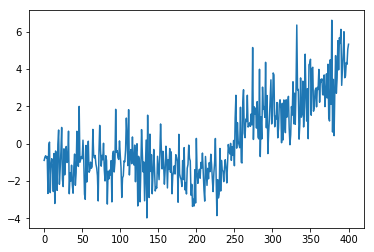

episode: 10025   score: 360.0  step_count: 187   memory length: 2000   epsilon: 0.04941507162815284
episode: 10050   score: 88.0  step_count: 140   memory length: 2000   epsilon: 0.049045844996558396
episode: 10075   score: 881.0  step_count: 171   memory length: 2000   epsilon: 0.04867937720611454
episode: 10100   score: 664.0  step_count: 155   memory length: 2000   epsilon: 0.04831564764291141
episode: 10125   score: 783.0  step_count: 146   memory length: 2000   epsilon: 0.04795463584706521
episode: 10150   score: 903.0  step_count: 150   memory length: 2000   epsilon: 0.047596321511567195
episode: 10175   score: 333.0  step_count: 183   memory length: 2000   epsilon: 0.04724068448114156
episode: 10200   score: 1084.0  step_count: 158   memory length: 2000   epsilon: 0.04688770475111156
episode: 10225   score: 1030.0  step_count: 144   memory length: 2000   epsilon: 0.04653736246627427
episode: 10250   score: 620.0  step_count: 169   memory length: 2000   epsilon: 0.046189637919783

episode: 12075   score: 1350.0  step_count: 134   memory length: 2000   epsilon: 0.026715813160409614
episode: 12100   score: 1145.0  step_count: 135   memory length: 2000   epsilon: 0.02651619414373234
episode: 12125   score: 1350.0  step_count: 138   memory length: 2000   epsilon: 0.026318066669404745
episode: 12150   score: 1268.0  step_count: 139   memory length: 2000   epsilon: 0.02612141959270415
episode: 12175   score: 1500.0  step_count: 138   memory length: 2000   epsilon: 0.02592624185218062
episode: 12200   score: 980.0  step_count: 126   memory length: 2000   epsilon: 0.025732522469034826
episode: 12225   score: 1323.0  step_count: 132   memory length: 2000   epsilon: 0.025540250546500363
episode: 12250   score: 1259.0  step_count: 154   memory length: 2000   epsilon: 0.02534941526923089
episode: 12275   score: 1529.0  step_count: 141   memory length: 2000   epsilon: 0.025160005902691757
episode: 12300   score: 1278.0  step_count: 150   memory length: 2000   epsilon: 0.0249

episode: 14125   score: 367.0  step_count: 109   memory length: 2000   epsilon: 0.014443665739551319
episode: 14150   score: 414.0  step_count: 112   memory length: 2000   epsilon: 0.014335743535654163
episode: 14175   score: 693.0  step_count: 125   memory length: 2000   epsilon: 0.014228627720548313
episode: 14200   score: 723.0  step_count: 120   memory length: 2000   epsilon: 0.014122312268940937
episode: 14225   score: 207.0  step_count: 112   memory length: 2000   epsilon: 0.014016791200559861
episode: 14250   score: 592.0  step_count: 124   memory length: 2000   epsilon: 0.013912058579817144
episode: 14275   score: 570.0  step_count: 121   memory length: 2000   epsilon: 0.013808108515475263
episode: 14300   score: 456.0  step_count: 120   memory length: 2000   epsilon: 0.013704935160315691
episode: 14325   score: 828.0  step_count: 113   memory length: 2000   epsilon: 0.01360253271081001
episode: 14350   score: 589.0  step_count: 119   memory length: 2000   epsilon: 0.0135008954

episode: 16175   score: 754.0  step_count: 109   memory length: 2000   epsilon: 0.007808840970570579
episode: 16200   score: 441.0  step_count: 105   memory length: 2000   epsilon: 0.00775049381363186
episode: 16225   score: 373.0  step_count: 113   memory length: 2000   epsilon: 0.007692582623451245
episode: 16250   score: 684.0  step_count: 122   memory length: 2000   epsilon: 0.007635104142509019
episode: 16275   score: 468.0  step_count: 126   memory length: 2000   epsilon: 0.007578055137625479
episode: 16300   score: 775.0  step_count: 121   memory length: 2000   epsilon: 0.007521432399779045
episode: 16325   score: 449.0  step_count: 120   memory length: 2000   epsilon: 0.007465232743925789
episode: 16350   score: 639.0  step_count: 135   memory length: 2000   epsilon: 0.0074094530088202595
episode: 16375   score: 229.0  step_count: 115   memory length: 2000   epsilon: 0.007354090056837634
episode: 16400   score: 466.0  step_count: 129   memory length: 2000   epsilon: 0.007299140

episode: 18225   score: 594.0  step_count: 121   memory length: 2000   epsilon: 0.004221783367248396
episode: 18250   score: 426.0  step_count: 121   memory length: 2000   epsilon: 0.004190238508082294
episode: 18275   score: 548.0  step_count: 114   memory length: 2000   epsilon: 0.004158929350374619
episode: 18300   score: 481.0  step_count: 140   memory length: 2000   epsilon: 0.004127854132976998
episode: 18325   score: 519.0  step_count: 117   memory length: 2000   epsilon: 0.004097011107900251
episode: 18350   score: 481.0  step_count: 129   memory length: 2000   epsilon: 0.0040663985402160895
episode: 18375   score: 328.0  step_count: 108   memory length: 2000   epsilon: 0.004036014707959514
episode: 18400   score: 515.0  step_count: 131   memory length: 2000   epsilon: 0.00400585790203194
episode: 18425   score: 376.0  step_count: 122   memory length: 2000   epsilon: 0.003975926426105087
episode: 18450   score: 569.0  step_count: 121   memory length: 2000   epsilon: 0.003946218

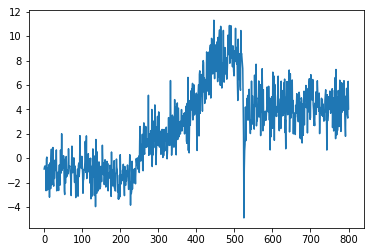

episode: 20025   score: 657.0  step_count: 132   memory length: 2000   epsilon: 0.0024602410516830564
episode: 20050   score: 571.0  step_count: 140   memory length: 2000   epsilon: 0.002441858340132627
episode: 20075   score: 565.0  step_count: 143   memory length: 2000   epsilon: 0.0024236129831951793
episode: 20100   score: 943.0  step_count: 142   memory length: 2000   epsilon: 0.0024055039545645717
episode: 20125   score: 619.0  step_count: 124   memory length: 2000   epsilon: 0.0023875302356031708
episode: 20150   score: 430.0  step_count: 114   memory length: 2000   epsilon: 0.0023696908152845476
episode: 20175   score: 585.0  step_count: 122   memory length: 2000   epsilon: 0.002351984690136601
episode: 20200   score: 470.0  step_count: 116   memory length: 2000   epsilon: 0.002334410864185126
episode: 20225   score: 678.0  step_count: 134   memory length: 2000   epsilon: 0.0023169683488977783
episode: 20250   score: 513.0  step_count: 129   memory length: 2000   epsilon: 0.002

episode: 22050   score: 527.0  step_count: 115   memory length: 2000   epsilon: 0.00134012478264167
episode: 22075   score: 570.0  step_count: 133   memory length: 2000   epsilon: 0.0013301115184497089
episode: 22100   score: 743.0  step_count: 126   memory length: 2000   epsilon: 0.0013201730728188727
episode: 22125   score: 345.0  step_count: 125   memory length: 2000   epsilon: 0.0013103088867089721
episode: 22150   score: 405.0  step_count: 144   memory length: 2000   epsilon: 0.0013005184052569383
episode: 22175   score: 724.0  step_count: 125   memory length: 2000   epsilon: 0.0012908010777456082
episode: 22200   score: 224.0  step_count: 129   memory length: 2000   epsilon: 0.0012811563575727488
episode: 22225   score: 737.0  step_count: 132   memory length: 2000   epsilon: 0.0012715837022203042
episode: 22250   score: 576.0  step_count: 154   memory length: 2000   epsilon: 0.0012620825732238886
episode: 22275   score: 448.0  step_count: 112   memory length: 2000   epsilon: 0.00

episode: 24075   score: 594.0  step_count: 116   memory length: 2000   epsilon: 0.0007299851905115339
episode: 24100   score: 472.0  step_count: 114   memory length: 2000   epsilon: 0.0007245308559046427
episode: 24125   score: 521.0  step_count: 119   memory length: 2000   epsilon: 0.0007191172757869327
episode: 24150   score: 450.0  step_count: 130   memory length: 2000   epsilon: 0.0007137441456430937
episode: 24175   score: 395.0  step_count: 131   memory length: 2000   epsilon: 0.0007084111632331393
episode: 24200   score: 665.0  step_count: 133   memory length: 2000   epsilon: 0.0007031180285754025
episode: 24225   score: 513.0  step_count: 105   memory length: 2000   epsilon: 0.0006978644439296638
episode: 24250   score: 630.0  step_count: 126   memory length: 2000   epsilon: 0.0006926501137804005
episode: 24275   score: 624.0  step_count: 124   memory length: 2000   epsilon: 0.0006874747448201675
episode: 24300   score: 675.0  step_count: 142   memory length: 2000   epsilon: 0.

episode: 26100   score: 944.0  step_count: 137   memory length: 2000   epsilon: 0.0003976354763132714
episode: 26125   score: 534.0  step_count: 124   memory length: 2000   epsilon: 0.00039466444055174453
episode: 26150   score: 424.0  step_count: 129   memory length: 2000   epsilon: 0.0003917156042065582
episode: 26175   score: 638.0  step_count: 129   memory length: 2000   epsilon: 0.00038878880140489074
episode: 26200   score: 756.0  step_count: 127   memory length: 2000   epsilon: 0.0003858838675133123
episode: 26225   score: 255.0  step_count: 103   memory length: 2000   epsilon: 0.00038300063912852564
episode: 26250   score: 611.0  step_count: 128   memory length: 2000   epsilon: 0.0003801389540681744
episode: 26275   score: 372.0  step_count: 116   memory length: 2000   epsilon: 0.00037729865136171866
episode: 26300   score: 373.0  step_count: 123   memory length: 2000   epsilon: 0.0003744795712413826
episode: 26325   score: 601.0  step_count: 112   memory length: 2000   epsilon

episode: 28100   score: 263.0  step_count: 108   memory length: 2000   epsilon: 0.0002182314882081529
episode: 28125   score: 786.0  step_count: 124   memory length: 2000   epsilon: 0.0002166009492109755
episode: 28150   score: 867.0  step_count: 123   memory length: 2000   epsilon: 0.00021498259351180064
episode: 28175   score: 501.0  step_count: 110   memory length: 2000   epsilon: 0.00021337633007769276
episode: 28200   score: 508.0  step_count: 128   memory length: 2000   epsilon: 0.00021178206855591058
episode: 28225   score: 562.0  step_count: 131   memory length: 2000   epsilon: 0.0002101997192688231
episode: 28250   score: 661.0  step_count: 136   memory length: 2000   epsilon: 0.0002086291932088657
episode: 28275   score: 602.0  step_count: 117   memory length: 2000   epsilon: 0.00020707040203353343
episode: 28300   score: 853.0  step_count: 125   memory length: 2000   epsilon: 0.000205523258060412
episode: 28325   score: 641.0  step_count: 119   memory length: 2000   epsilon:

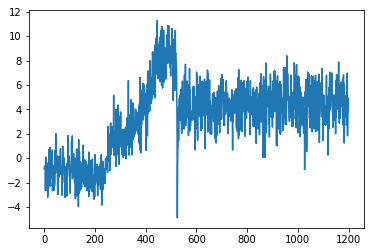

episode: 30025   score: 534.0  step_count: 136   memory length: 2000   epsilon: 0.00012249769157088625
episode: 30050   score: 636.0  step_count: 125   memory length: 2000   epsilon: 0.00012158247025413828
episode: 30075   score: 422.0  step_count: 137   memory length: 2000   epsilon: 0.0001206740874208974
episode: 30100   score: 558.0  step_count: 109   memory length: 2000   epsilon: 0.00011977249197438974
episode: 30125   score: 249.0  step_count: 121   memory length: 2000   epsilon: 0.00011887763319963368
episode: 30150   score: 403.0  step_count: 118   memory length: 2000   epsilon: 0.00011798946076058723
episode: 30175   score: 413.0  step_count: 147   memory length: 2000   epsilon: 0.00011710792469731669
episode: 30200   score: 598.0  step_count: 107   memory length: 2000   epsilon: 0.00011623297542318564
episode: 30225   score: 552.0  step_count: 113   memory length: 2000   epsilon: 0.00011536456372206695
episode: 30250   score: 407.0  step_count: 113   memory length: 2000   eps

episode: 32050   score: 558.0  step_count: 124   memory length: 2000   epsilon: 6.673038630416602e-05
episode: 32075   score: 445.0  step_count: 132   memory length: 2000   epsilon: 6.623185523525536e-05
episode: 32100   score: 556.0  step_count: 141   memory length: 2000   epsilon: 6.573704916316257e-05
episode: 32125   score: 352.0  step_count: 138   memory length: 2000   epsilon: 6.524594025491561e-05
episode: 32150   score: 481.0  step_count: 132   memory length: 2000   epsilon: 6.475850088550888e-05
episode: 32175   score: 525.0  step_count: 127   memory length: 2000   epsilon: 6.427470363634938e-05
episode: 32200   score: 439.0  step_count: 118   memory length: 2000   epsilon: 6.379452129371436e-05
episode: 32225   score: 272.0  step_count: 118   memory length: 2000   epsilon: 6.33179268472202e-05
episode: 32250   score: 562.0  step_count: 118   memory length: 2000   epsilon: 6.284489348830377e-05
episode: 32275   score: 560.0  step_count: 121   memory length: 2000   epsilon: 6.2

episode: 34075   score: 657.0  step_count: 120   memory length: 2000   epsilon: 3.635332471684228e-05
episode: 34100   score: 588.0  step_count: 122   memory length: 2000   epsilon: 3.608176938686777e-05
episode: 34125   score: 359.0  step_count: 117   memory length: 2000   epsilon: 3.5812243103432406e-05
episode: 34150   score: 648.0  step_count: 121   memory length: 2000   epsilon: 3.554473070561167e-05
episode: 34175   score: 967.0  step_count: 122   memory length: 2000   epsilon: 3.5279217145762646e-05
episode: 34200   score: 560.0  step_count: 125   memory length: 2000   epsilon: 3.50156874886776e-05
episode: 34225   score: 733.0  step_count: 131   memory length: 2000   epsilon: 3.475412691074388e-05
episode: 34250   score: 828.0  step_count: 131   memory length: 2000   epsilon: 3.449452069910989e-05
episode: 34275   score: 341.0  step_count: 112   memory length: 2000   epsilon: 3.423685425085785e-05
episode: 34300   score: 661.0  step_count: 130   memory length: 2000   epsilon: 3

In [ ]:

env = CabDriver()      #creating an instance of the class

# get size of state and action from environment
state_size = env.state_size 
action_size = env.action_size

#Call the DQN agent
agent = DQNAgent(state_size, action_size)

# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    state = env.reset()
    initial_state = state    #for the purpose of tracking reward
    
    terminal_state = False
    step_count = 0
    tot_reward = 0
    
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        action, action_index, epsilon = agent.get_action(state)
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)
        
        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action_index, reward, next_state, terminal_state)

        # every time step do the training
        agent.train_model()
        
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards
        if terminal_state and episode % 25 == 0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode, "  score:", tot_reward, " step_count:",
                      step_count, "  memory length:",
                      len(agent.memory), "  epsilon:", epsilon)
    
    if episode % 200 == 0:
            agent.save("./cab_driver.h5")

    if episode % 100 == 0:   #every 2000th episode
        save_obj(avg_reward,'Rewards')   
        save_tracking_states(agent)
        save_obj(states_track,'states_tracked')   
        
    
    if episode % 10000 ==0 and episode !=0:
        plt.plot(list(range(len(avg_reward))), avg_reward)
        plt.show()

### Tracking Convergence

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [6]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

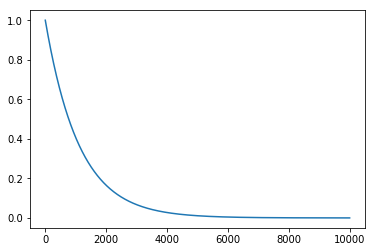

In [7]:
plt.plot(time, epsilon)
plt.show()